In [26]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

In [27]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

--2022-06-10 07:41:51--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-06-10 07:41:51 (115 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [28]:
tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [29]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [30]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

In [31]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [32]:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_flowers_label=None, tf_flowers_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_flowers_label is not None:
    ax1.set_title(tf_flowers_labels[correct_flowers_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not tf_flowers_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(tf_flowers_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

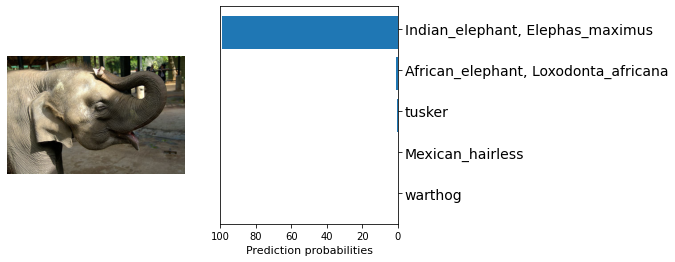

In [33]:
# Load image (image provided is CC0 licensed)
img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

# Run model on image
logits = imagenet_module(image)

# Show image and predictions
show_preds(logits, image[0])

In [34]:
# Import tf_flowers data from tfds

dataset_name = 'tf_flowers'
ds, info = tfds.load(name=dataset_name, split=['train'], with_info=True)
ds = ds[0]
num_examples = info.splits['train'].num_examples
NUM_CLASSES = 5

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [35]:
#@title Alternative code for loading a dataset
#@markdown We provide alternative code for loading `tf_flowers` from an URL in this cell to make it easy for you to try loading your own datasets. 

#@markdown This code is commented out by default and replaces the cell immediately above. Note that using this option may result in a different example image below.
"""
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = tf_flowers_labels  # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
"""

"\ndata_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',\n                                         fname='flower_photos', untar=True)\ndata_dir = pathlib.Path(data_dir)\n\nIMG_HEIGHT = 224\nIMG_WIDTH = 224\n\nCLASS_NAMES = tf_flowers_labels  # from plotting helper functions above\nNUM_CLASSES = len(CLASS_NAMES)\nnum_examples = len(list(data_dir.glob('*/*.jpg')))\n\ndef get_label(file_path):\n  # convert the path to a list of path components\n  parts = tf.strings.split(file_path, os.path.sep)\n  # The second to last is the class-directory\n  \n  return tf.where(parts[-2] == CLASS_NAMES)[0][0]\n\ndef decode_img(img):\n  # convert the compressed string to a 3D uint8 tensor\n  img = tf.image.decode_jpeg(img, channels=3)\n  return img  \n\ndef process_path(file_path):\n  label = get_label(file_path)\n  # load the raw data from the file as a string\n  img = tf.io.read_file(file_path)\n  img = decode_img(img)\n  fe

In [36]:
train_split = 0.9
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

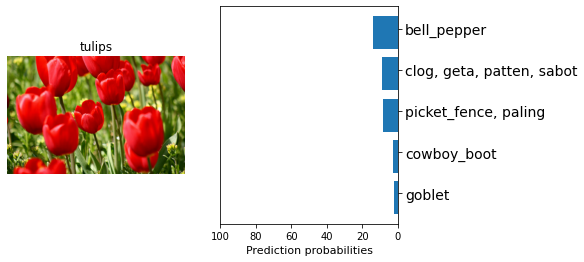

In [37]:
for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)

  # Run model on image
  logits = imagenet_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_flowers_label=features['label'].numpy())

In [38]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [39]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [40]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 512
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [41]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [42]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/50
10/10 [==============================] - 461s 43s/step - loss: 0.4058 - accuracy: 0.8467 - val_loss: 0.0984 - val_accuracy: 0.9809
Epoch 2/50
10/10 [==============================] - 420s 43s/step - loss: 0.1697 - accuracy: 0.9518 - val_loss: 0.1091 - val_accuracy: 0.9782
Epoch 3/50
10/10 [==============================] - 408s 41s/step - loss: 0.1387 - accuracy: 0.9607 - val_loss: 0.0981 - val_accuracy: 0.9755
Epoch 4/50
10/10 [==============================] - 405s 41s/step - loss: 0.1098 - accuracy: 0.9691 - val_loss: 0.0884 - val_accuracy: 0.9809
Epoch 5/50
10/10 [==============================] - 413s 42s/step - loss: 0.0964 - accuracy: 0.9713 - val_loss: 0.0877 - val_accuracy: 0.9782
Epoch 6/50
10/10 [==============================] - 411s 42s/step - loss: 0.0728 - accuracy: 0.9770 - val_loss: 0.0853 - val_accuracy: 0.9864
Epoch 7/50
10/10 [==============================] - 410s 41s/step - loss: 0.0647 - accuracy: 0.9795 - val_loss: 0.0804 - val_accuracy: 0.9782
Epoch 